# Convolutional neural network for classifying Root data fits.


Here, we define, train, and save new convolutional models as well as some 
simple model evaluation. 
We define hyper-parameters, number of layers, and 
training and testing datasets. 

# The data
The data consists of png files output by Root C++ interpreter. The pngs are of histograms, the black data points show the number of events for a given signal size (counts on the y-axis, signal size on the x-axis). The signal comes from a PMT (photo-multiplier tube).

Along with the images, there are some sets of numbers including: 
 - run parameters
   * voltage
   * light level
   * filter 
   * pmt 
   * ADC channel 
   * etc.
 - fit inputs and outputs
   * initial signal size guess
   * initial signal rms guess
   * initial light level guess
   * converged signal size value
   * error on signal size output value
   * Chi-squared
   * etc.

## Dependencies:
 - **keras, tensorflow, numpy** (neural net math)
 - **scipy, matplotlib** (image handling)
 - **nn_utils** *(included)* (loading and preprocessing data)

## Load necessary packages

In [1]:
# Load some packages

# Keras packages for network
from keras.layers import Input, Dense, Activation, ZeroPadding2D
from keras.layers import BatchNormalization, Concatenate, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Conv2D
from keras.models import Model
from keras.optimizers import Adam, SGD
# For saving model
from keras.models import model_from_json
# For plotting and drawing after training
from keras.utils import plot_model

# Need numpy for linear algebra
import numpy as np
# Need misc ad matplotlib for image manipulation
from scipy import misc
#from PIL import Image
import matplotlib.pyplot as plt

# Import personal functions for loading dataset
import nn_utils as utils

# Use magic function for plotting
%matplotlib inline

Using TensorFlow backend.


## Load root fit data from file

Here, we load training data set and labels for training our CNN. 

### *Convolutional dataset consists of*
 - Linear scale png output of data points and fit lines
 - Log scale png output from the same fit
 - Fit input parameters such as high voltage, light level, minimum and maximum bounds to parameters
 - Fit output parameters such as signal mean and rms, gain measurement, chi squared per DOF, errors on parameters, etc.
 - Label (0 = bad fit, 1 = good fit)

In [6]:
# Load training images
x, x_log, in_params, out_params, y = utils.load_dataset_no_sql(dataset="train")
m, h, w, c = x.shape
input_shape = h, w, c
print(str(m) + " images loaded of shape " + str(input_shape))
print(str(y.shape[0]) + " labels loaded")
num_inputs, num_outputs = len(in_params[1]), len(out_params[1])
print(str(len(in_params)) + " input arrays loaded of length " + str(num_inputs))
print(str(len(out_params)) + " output arrays loaded of length " + str(num_outputs))

32 images loaded of shape (236, 348, 3)
32 labels loaded
32 input arrays loaded of length 38
32 output arrays loaded of length 20


### Load DEV set

Here, we load development set images for model evaluation.

In [7]:
# Load training images
x_dev, x_log_dev, in_params_dev, out_params_dev, y_dev = utils.load_dataset_no_sql(dataset="dev")
m_dev = x_dev.shape[0]
print(str(m_dev) + " dev examples loaded")

3 dev examples loaded


### Print an image

label: good
label: [1]

fit_inputs: [ 4.00000000e+00  2.00000000e+03  1.00000000e+02  2.00000000e+03
  4.60000000e+01  7.00000000e+00  0.00000000e+00  1.00000000e+03
  1.00000000e+00  1.00000000e+00  1.60000000e+01  5.00000000e-02
  6.13806921e+02  2.59090800e+00  5.00000000e-03  1.38000000e+00
  4.00000000e+00  2.59090800e+00  4.76190000e-02  9.52381000e-01
  1.00000000e-03 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  1.24200000e+00 -1.00000000e+00 -1.00000000e+00  4.28570000e-02
  9.47619000e-01  3.00000000e-01 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00  1.51800000e+00 -1.00000000e+00 -1.00000000e+00
  5.23810000e-02  9.57143000e-01]

fit_outputs: [4.49600000e-03 6.11732964e+02 1.91337200e+00 3.73860000e-02
 1.31145900e+00 8.02303000e-01 5.13300000e-02 9.47619000e-01
 1.66000000e-04 4.60230000e-02 1.78770000e-02 1.15600000e-03
 3.39900000e-02 7.35670000e-02 1.16100000e-03 8.12000000e-04
 3.33283400e+00 5.86704000e-01 1.78910000e-02 3.04934300e+00]


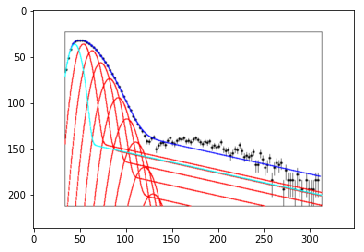

In [10]:
# Choose an image
index = 2

# Choose log or linear scale
log_scale = True


this_image = x_log[index] if log_scale else x[index]
if y[index] == 1:
    print("label: good")
else:
    print("label: bad")
print("label: " + str(y[index]))
print("\nfit_inputs: " + str(in_params[index]))
print("\nfit_outputs: " + str(out_params[index]))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

# Define and train convolutional neural net

### *Architecture:*
 - We will actually train two conv nets in parallel side-by-side, one looking at linear scale images while the other looks at log scale images. 
 - After we put the images through the multiple convolutional layers, we will flatten them into 1D arrays and concatenate them together.
 - To this array, we will concatenate all the useful values that were input to and output from the fit algorithm.
 - We now should have all the information avaiable from the fit contained in a single array of values that we can send into a deep, fully-connected network for classification.

### *Convolutional layers:*
 - We use 3 conv layers with batch normalization, dropout, and minimal pooling.
 - In a single convolutional layer, we will scan over our images with a certain stride and a certain kernal size (with multiple filters each time). 
 - As long as our kernel size or stride is greater than 1, we will be decreasing the size of the image with each pass through a convolutional layer (we are using no padding). 
 - Through applying filters in convolution as well as using max pooling, we will end up with a very reduced representation of our image; we hope that this still contains all the information necessary to classify it as a good/bad fit.

In [11]:
# Define Conv layers
filters = []
kernels = []
strides = []
pools = []
dropouts = []

# Conv1
filters.append(32)
kernels.append(5)
strides.append(3)
pools.append(1)
dropouts.append(0.1)

# Conv2
filters.append(64)
kernels.append(7)
strides.append(2)
pools.append(1)
dropouts.append(0.1)

# Conv3
filters.append(128)
kernels.append(9)
strides.append(3)
pools.append(2)
dropouts.append(0.2)

# Define dense layers
neurons = [100, 80, 60, 40, 20, 10]

## Define keras layers (model)

Our model contains two convolutional models in parallel, each with multiple layers. We run two in parallel to utilize log scale images AND linear scale (different information present). 

After we convolve the images, we flatten them and concatenate them. We also concatenate to them a list of inputs and outputs to and from the root fit algorithm such as parameter initial condition and bounds, output parameters plus errors, and chi-squared per degree of freedom.

After concatenating these three sources of information together, we send them through some fully-connected layers to allow learning from all three sources simultaneously.

Dropout is used here for regularization.
Pooling is used here to speed up computation.
Batch normalization is used to aid in learning at deeper layers.

In [12]:
# Define input layer (RGB image matrix)
X = Input(shape=input_shape, name='Input')

# Define additional input info
X_log = Input(shape=input_shape, name='InputLog')

# Define additional input info
In_params = Input(shape=(num_inputs,), name='In_params')
Out_params = Input(shape=(num_outputs,), name='Out_params')

# Initialize activation as input
a = X
a_log = X_log
# Loop through all convolutional layers
for i in range(len(filters)):
    # Perform convolution
    a = Conv2D(filters=filters[i], kernel_size=(kernels[i], kernels[i]), strides=(strides[i], strides[i]), name=('conv' + str(i)))(a)
    a_log = Conv2D(filters=filters[i], kernel_size=(kernels[i], kernels[i]), strides=(strides[i], strides[i]), name=('conv_log' + str(i)))(a_log)
    # Normalize
    a = BatchNormalization(axis=3, name=('bn' + str(i)))(a)
    a_log = BatchNormalization(axis=3, name=('bn_log' + str(i)))(a_log)
    # Activate
    a = Activation('elu', name=('a' + str(i)))(a)
    a_log = Activation('elu', name=('a_log' + str(i)))(a_log)
    # Max-pool
    a = MaxPooling2D((pools[i], pools[i]), name=('max_pool' + str(i)))(a)
    a_log = MaxPooling2D((pools[i], pools[i]), name=('max_pool_log' + str(i)))(a_log)
    # Dropout
    a = Dropout(rate=dropouts[i])(a)
    a_log = Dropout(rate=dropouts[i])(a_log)

# Flatten output of convNet
a = Flatten()(a)
a_log = Flatten()(a_log)

a_both = Concatenate()([a, a_log])

# Concatenate and normalize input/output parameters
params = Concatenate()([In_params, Out_params])
params = BatchNormalization(name='bn_params')(params)

# Concatenate parameters to activations
a = Concatenate()([a_both, params])

# Loop through dense layers
for i in range(len(neurons)):
    a = Dense(units=neurons[i], activation='relu', name=('fc' + str(i)))(a)
    a = Dropout(rate=0.2)(a)
    
# Define output layer 
a = Dense(units=1, activation='sigmoid', name='sigmoid')(a)

# Make the model
model = Model(inputs=[X, X_log, In_params, Out_params], outputs=a)

##### Define optimizer, loss, and metrics. Compile model.

In [13]:
# Define optimizer
#opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001)
opt = SGD(lr=1.0, decay=1e-6, momentum=0.9, nesterov=True)
# Define loss
loss = 'mean_squared_error'
# Define metrics to use
metrics=['acc']
# Compile model
model.compile(loss=loss, optimizer='sgd', metrics=metrics)
# Print summary
model.summary()
# Initialize histories list for storing training results
histories = []

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 236, 348, 3)  0                                            
__________________________________________________________________________________________________
InputLog (InputLayer)           (None, 236, 348, 3)  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 78, 115, 32)  2432        Input[0][0]                      
__________________________________________________________________________________________________
conv_log0 (Conv2D)              (None, 78, 115, 32)  2432        InputLog[0][0]                   
__________________________________________________________________________________________________
bn0 (Batch

## Fit the model to the data (train)

In [14]:
# Now, fit the model to the data
num_epochs = 40
num_loops = 5
size_of_batches = 128
for ii in range(num_loops):
    history = model.fit([x, x_log, in_params, out_params], y, validation_data=([x_dev, x_log_dev, in_params_dev, out_params_dev], y_dev), epochs=num_epochs, batch_size=64)
    histories.append(history)

Train on 32 samples, validate on 3 samples
Epoch 1/100
32/32 [==============================] - 4s 120ms/step - loss: 0.2629 - acc: 0.4688 - val_loss: 0.2723 - val_acc: 0.3333
Epoch 2/100
32/32 [==============================] - 2s 67ms/step - loss: 0.2936 - acc: 0.5000 - val_loss: 0.2634 - val_acc: 0.3333
Epoch 3/100
32/32 [==============================] - 3s 86ms/step - loss: 0.2578 - acc: 0.6250 - val_loss: 0.2614 - val_acc: 0.3333
Epoch 4/100
32/32 [==============================] - 3s 94ms/step - loss: 0.2842 - acc: 0.5625 - val_loss: 0.2471 - val_acc: 0.3333
Epoch 5/100
32/32 [==============================] - 3s 81ms/step - loss: 0.2646 - acc: 0.5312 - val_loss: 0.2547 - val_acc: 0.3333
Epoch 6/100
32/32 [==============================] - 3s 102ms/step - loss: 0.2466 - acc: 0.6250 - val_loss: 0.2503 - val_acc: 0.3333
Epoch 7/100
32/32 [==============================] - 3s 82ms/step - loss: 0.2513 - acc: 0.5938 - val_loss: 0.2793 - val_acc: 0.3333
Epoch 8/100
32/32 [============

Epoch 63/100
32/32 [==============================] - 2s 48ms/step - loss: 0.1716 - acc: 0.7500 - val_loss: 0.2275 - val_acc: 0.6667
Epoch 64/100
32/32 [==============================] - 2s 48ms/step - loss: 0.1865 - acc: 0.6875 - val_loss: 0.2393 - val_acc: 0.6667
Epoch 65/100
32/32 [==============================] - 2s 49ms/step - loss: 0.2118 - acc: 0.7188 - val_loss: 0.2226 - val_acc: 0.6667
Epoch 66/100
32/32 [==============================] - 2s 49ms/step - loss: 0.1945 - acc: 0.6875 - val_loss: 0.2396 - val_acc: 0.6667
Epoch 67/100
32/32 [==============================] - 2s 50ms/step - loss: 0.1968 - acc: 0.6562 - val_loss: 0.2212 - val_acc: 0.6667
Epoch 68/100
32/32 [==============================] - 2s 49ms/step - loss: 0.1358 - acc: 0.7812 - val_loss: 0.2455 - val_acc: 0.3333
Epoch 69/100
32/32 [==============================] - 2s 49ms/step - loss: 0.2230 - acc: 0.6875 - val_loss: 0.2308 - val_acc: 0.6667
Epoch 70/100
32/32 [==============================] - 2s 50ms/step - 

KeyboardInterrupt: 

### Print training results

Looking at how the accuracy and the value of the loss function change while training the model can help us identify what the model is learning, how fast it is learning it, if the model is overtraining, how noisy the dataset is, etc.

If the dataset contains sufficient examples and information for our model to really learn the essence of what makes a good fit, and if the model is sufficiently complex or elegant, then we expect the accuracy to approach 100% while the loss approaches zero.

dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])


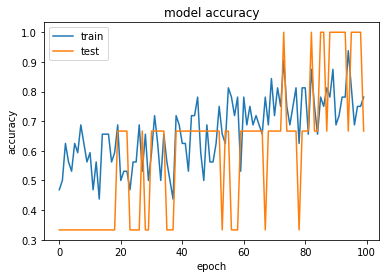

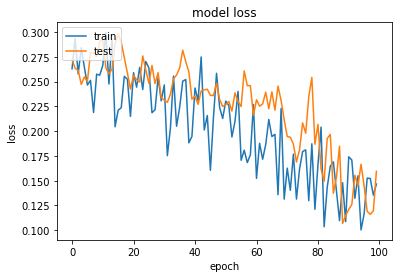

In [17]:
# Choose which training iteration to look at 
index = 0
print(histories[index].history.keys())

# Summarize history for accuracy
plt.plot(histories[index].history['acc'])
plt.plot(histories[index].history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(histories[index].history['loss'])
plt.plot(histories[index].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Additional model evaluation

Looking at the number of right answers vs. wrong answers in different ways can tell us specific information about the progress of the model. Accuracy is one way to evaluate our model; accuracy is the number of correct classifications divided by the number of total classifications. Two more values called precision and recall can tell us more about why the accuracy might not reach 100%.

Right answers consist of two types: true positives and true negatives. If the model correctly classifies a good fit, that is a true positive; if the model correctly classifies a bad fit, then it is a true negative. If our model classifies a bad fit as good, this is a false positive. 

Precision is the number of true positives divided by the sum of true and false positives. So for us, precision is the number of correctly classified good fits out of how many fits were classified as good. This number gives us an idea of how much we can trust our model when it says we have a good fit.

Recall is the number of true positives divided by the sum of true positives and false negatives. In other words, recall is how many good fits were identified out of all the good fits there were.

In [24]:
# Choose which model to evaluate
choice = "train"

# Get stats from model, get model predictions
if choice == "train":
    stats = model.evaluate([x, x_log, in_params, out_params], y)
    predictions = model.predict([x, x_log, in_params, out_params])
    good_fits = y
    m_eval = m
elif choice == "dev":
    stats = model.evaluate([x_dev, x_log_dev, in_params_dev, out_params_dev], y_dev)
    predictions = model.predict([x_dev, x_log_dev, in_params_dev, out_params_dev])
    good_fits = y_dev
    m_eval = m_dev
predictions = np.floor(predictions + 0.5)

# Get vector mask for good and bad fits and right and wrong answers
bad_fits = 1 - good_fits
wrong_answers = np.abs(np.subtract(predictions, good_fits))
right_answers = np.subtract(1, wrong_answers)
# Calculate true positives (tp), as well as (tn) (fp) (fn)
true_positives = np.multiply(right_answers, good_fits)
true_negatives = np.multiply(right_answers, bad_fits)
false_positives = np.multiply(wrong_answers, good_fits)
false_negatives = np.multiply(wrong_answers, bad_fits)
# Calculate additional metrics
precision = np.sum(true_positives) / np.sum(true_positives + false_positives)
recall = np.sum(true_positives) / np.sum(true_positives + false_negatives)

# Print stats
print()
print("Performance on VALIDATION set")
print(".............................")
print("Loss: " + str(stats[0]))
print("Accuracy: " + str(stats[1]))
print("Precision: " + str(precision))
print("Recall: " + str(recall))

# Print list of indices of wrong answers
bad_list = []
for i in range(m_eval):
    if wrong_answers[i] == 1:
        bad_list.append(i)
print(".............................")
print("List of indices of wrong guesses:")
print(bad_list)

32/32 [==============================] - 0s 13ms/step

Performance on VALIDATION set
.............................
Loss: 0.038836926221847534
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
.............................
List of indices of wrong guesses:
[]


## Look at an image

label: [0]
prediction: [0.]
(236, 348, 3)


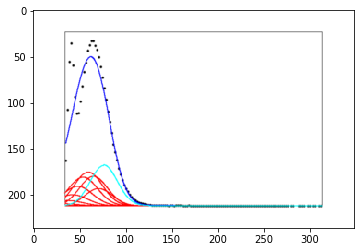

In [25]:
# Choose an index 
index = 0

# Print labels for this index
print("label: " + str(good_fits[index]))
print("prediction: " + str(predictions[index]))

# Show image
this_image = x[index]
print(str(this_image.shape))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

## Load pretrained conv model

In [25]:
# load json and create model
json_file = open('trained/conv_all.json', 'r')
conv_model_json = json_file.read()
json_file.close()
model = model_from_json(conv_model_json)
# load weights into new model
model.load_weights("trained/conv_all.h5")
print("Loaded model from disk")

Loaded model from disk


## Save convolutional model to disc

In [32]:
# serialize model to JSON
model_json = model.to_json()
with open("trained/conv_all.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("trained/conv_all.h5")
print("Saved model to disk")

Saved model to disk
